In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas  # noqa

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS

epoch_key = ('jaq', 1, 2)

In [4]:
from loren_frank_data_processing.position import _get_pos_dataframe

position_info = _get_pos_dataframe(epoch_key, ANIMALS)

position_info

x_position  y_position  head_direction      speed
time                                                              
00:43:30.546587   28.574616   50.447565       -0.524582  27.167580
00:43:30.579912   29.310925   49.945874       -0.494816  25.101432
00:43:30.613259   30.008352   49.527413       -0.450793  23.123634
00:43:30.646584   30.662594   49.193986       -0.387945  21.354751
00:43:30.679908   31.271801   48.949128       -0.309834  19.746150
...                     ...         ...             ...        ...
01:17:35.622190    4.356638   28.791833        3.062665   1.008224
01:17:35.655514    4.365645   28.752353        3.115665   1.169370
01:17:35.688860    4.375367   28.704734       -3.102260   1.425742
01:17:35.722185    4.387020   28.631174       -3.010876   2.064580
01:17:35.755531    4.408966   28.504623       -2.889136   3.115258

[61358 rows x 4 columns]

In [5]:
position_info.hvplot.line('x_position', 'y_position', height=500, width=500)

:Curve   [x_position]   (y_position)

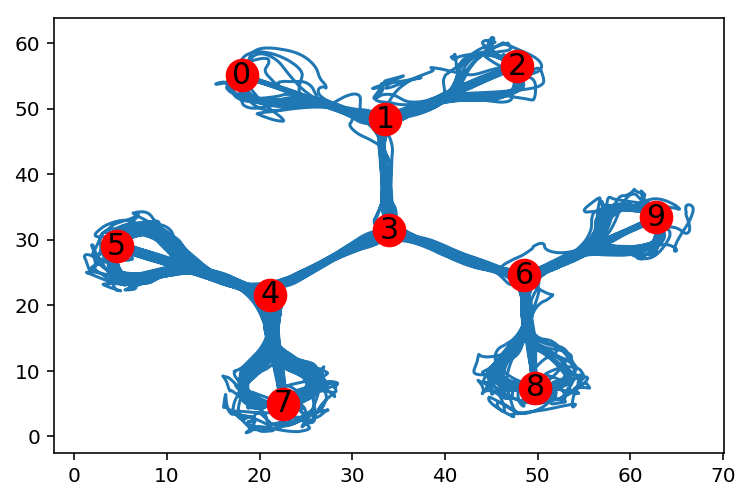

In [103]:
node_positions = np.array([
    (18.091, 55.053), # top left well 0
    (33.583, 48.357), # top middle intersection 1
    (47.753, 56.512), # top right well 2
    (33.973, 31.406), # middle intersection 3
    (21.166, 21.631),  # bottom left intersection 4
    (04.585, 28.966), # middle left well 5 
    (48.539, 24.572), # middle right intersection 6
    (22.507, 05.012),  # bottom left well 7 
    (49.726, 07.439),  # bottom right well 8
    (62.755, 33.410), # middle right well 9
])

edges = np.array([
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (3, 6),
    (6, 9),
    (4, 7),
    (6, 8),
])

track_segments = np.array([(node_positions[e1], node_positions[e2]) for e1, e2 in edges])
edge_distances = np.linalg.norm(
    np.diff(track_segments, axis=-2).squeeze(), axis=1)

plt.plot(position_info.x_position, position_info.y_position)
plt.scatter(node_positions[:, 0], node_positions[:, 1], color='red', zorder=10, s=250)
for i, (x, y) in enumerate(node_positions):
    plt.text(x, y, i, zorder=10, ha='center', va='center', fontsize=15, color='black')

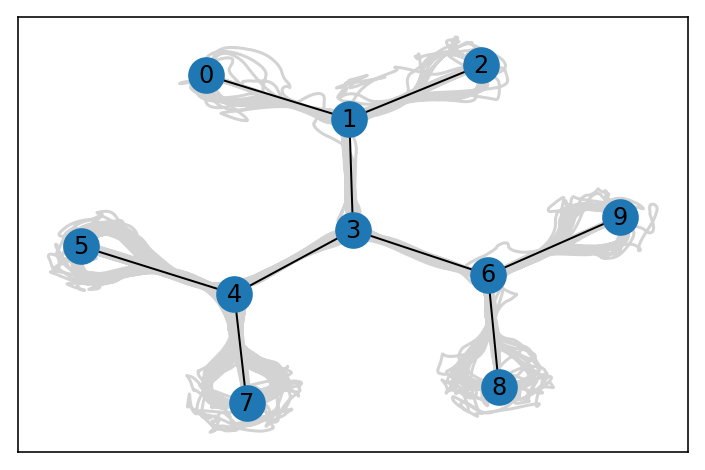

In [104]:
import networkx as nx
from loren_frank_data_processing.track_segment_classification import plot_track

track_graph = nx.Graph()

for node_id, node_position in enumerate(node_positions):
    track_graph.add_node(node_id, pos=tuple(node_position))

for edge, distance in zip(edges, edge_distances):
    nx.add_path(track_graph, edge, distance=distance)
    
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey', zorder=-1)    
plot_track(track_graph)

In [130]:
from loren_frank_data_processing.track_segment_classification import classify_track_segments

position = position_info.loc[:, ['x_position', 'y_position']].values

track_segment_id = classify_track_segments(
    track_graph, position,
    route_euclidean_distance_scaling=0.1,
    sensor_std_dev=10)

In [131]:
position_info['track_segment_id'] = track_segment_id

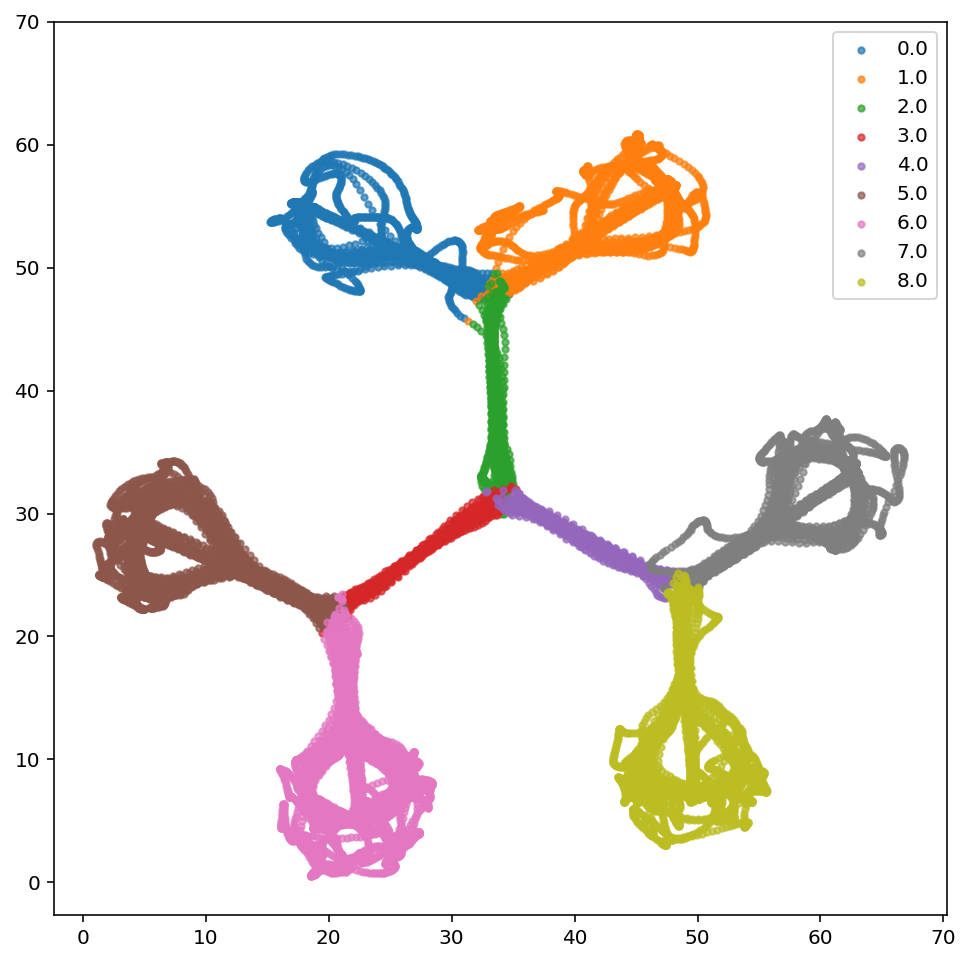

In [132]:
fig, ax = plt.subplots(figsize=(8, 9))

for edge_label, df in position_info.groupby('track_segment_id'):
    ax.scatter(df.x_position, df.y_position, s=10, alpha=0.7, label=edge_label)
plt.legend()
plt.axis('square');

In [135]:
from loren_frank_data_processing.track_segment_classification import calculate_linear_distance

center_well_id = 7

linear_distance = calculate_linear_distance(
    track_graph, track_segment_id, center_well_id, position)

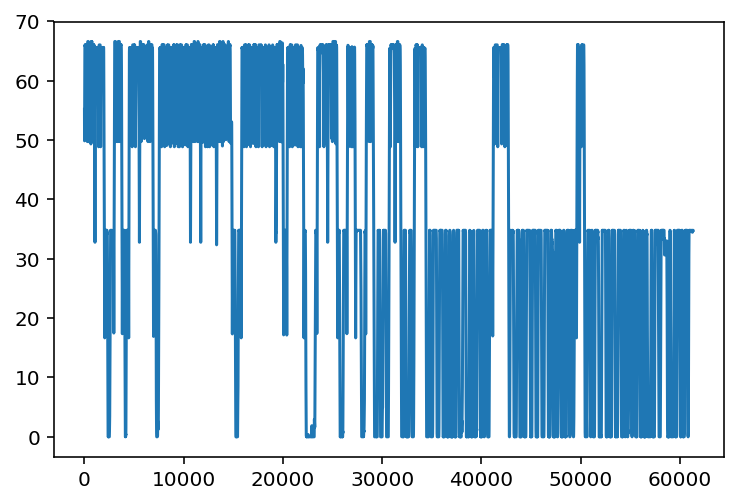

In [136]:
plt.plot(linear_distance)

In [147]:
linear_position = linear_distance.copy()

linear_edge_order = [6, 5, 3, 8, 7, 4, 2, 0, 1]
spacing = 15

for prev_edge, cur_edge in zip(linear_edge_order[:-1], linear_edge_order[1:]):
    is_cur_edge = (track_segment_id == cur_edge)
    is_prev_edge = (track_segment_id == prev_edge)
    
    cur_distance = linear_position[is_cur_edge]
    cur_distance -= cur_distance.min()
    cur_distance += linear_position[is_prev_edge].max() + spacing
    linear_position[is_cur_edge] = cur_distance
    

In [148]:
position_info['linear_position'] = linear_position

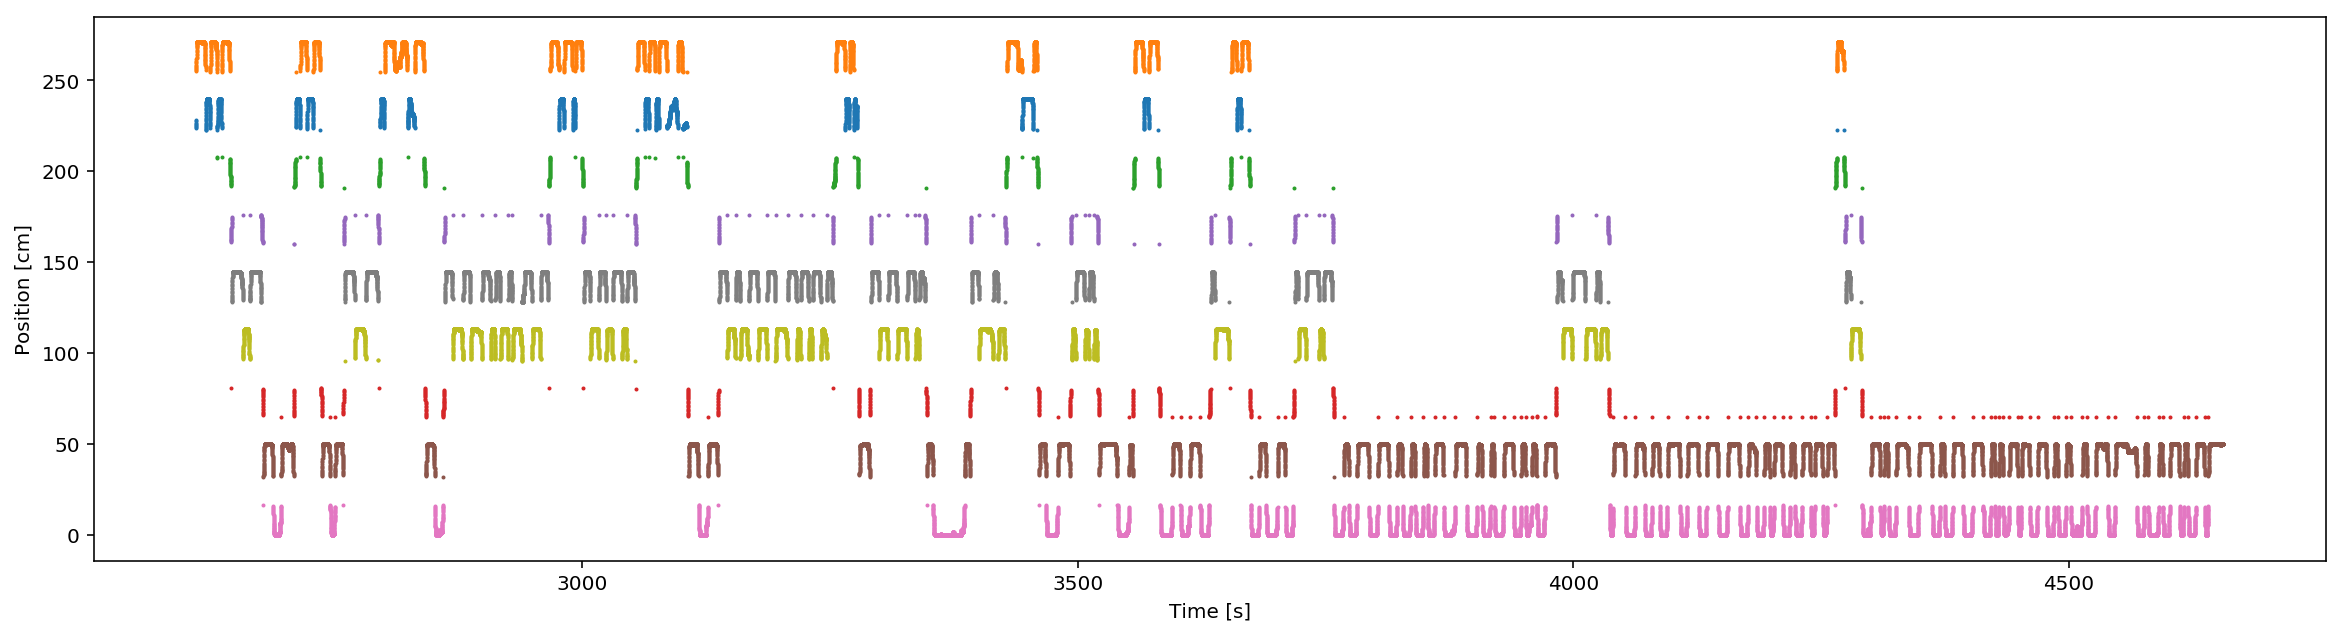

In [151]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in position_info.groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

In [5]:
from src.load_data import get_interpolated_position_info

p = get_interpolated_position_info(epoch_key, ANIMALS)

ValueError: not enough values to unpack (expected 2, got 1)

In [7]:
from src.load_data import make_track_graph

position_info = _get_pos_dataframe(epoch_key, ANIMALS)
position = position_info.loc[:, ['x_position', 'y_position']].values
track_graph, center_well_id = make_track_graph()
track_segment_id = pd.DataFrame(
        track_segment_id, index=position_info.index)